<a href="https://colab.research.google.com/github/Bappy60/ML_Assignment/blob/main/Final%20Lab%20Problem%201/X_ray_image_classification_with_CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Author Name : Kawsar Ahemmed Bappy*

*Registration Number : 2018831060*

#Importing Libraries

In [45]:
# importing all the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import tensorflow as tf
import math
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense , Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

!pip install google-colab
import google.colab.drive as drive

from sklearn.model_selection import train_test_split

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
SEED = 42

#Loading the Dataset



In [34]:
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/Archive.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/Archive.zip
replace test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Cheking the dataset

In [35]:
!ls -l

total 32604
-rw-r--r-- 1 root root 33353395 Jan 20 11:26 best_model_todate.data-00000-of-00001
-rw-r--r-- 1 root root     2101 Jan 20 11:26 best_model_todate.index
-rw-r--r-- 1 root root       91 Jan 20 11:26 checkpoint
drwx------ 5 root root     4096 Jan 20 11:04 drive
drwxr-xr-x 4 root root     4096 Jan 20 11:04 __MACOSX
drwxr-xr-x 1 root root     4096 Jan 18 14:21 sample_data
drwxr-xr-x 4 root root     4096 Jan  8 17:16 test
drwxr-xr-x 4 root root     4096 Jan  8 17:16 train
drwxr-xr-x 4 root root     4096 Jan  8 17:16 val


In [ ]:
!ls -l train/NORMAL

##Loading data into variable


In [52]:
import os
from pathlib import Path

training_path = 'train'
testing_path = 'test'
validation_path = 'val'

train_normal = Path(training_path) / 'NORMAL'
train_pneumonia = Path(training_path) / 'PNEUMONIA'
testing_normal = Path(testing_path) / 'NORMAL'
testing_pneumonia = Path(testing_path) / 'PNEUMONIA'

val_normal = Path(validation_path) / 'NORMAL'
val_pneumonia = Path(validation_path) / 'PNEUMONIA'

In [8]:
!ls -l /content

total 24
drwx------ 5 root root 4096 Jan 20 11:04 drive
drwxr-xr-x 4 root root 4096 Jan 20 11:04 __MACOSX
drwxr-xr-x 1 root root 4096 Jan 18 14:21 sample_data
drwxr-xr-x 4 root root 4096 Jan  8 17:16 test
drwxr-xr-x 4 root root 4096 Jan  8 17:16 train
drwxr-xr-x 4 root root 4096 Jan  8 17:16 val


#Data Augmentation & Data Generator
Data augmentation is a powerful technique which helps in almost every case for improving the robustness of a model. But augmentation can be much more helpful where the dataset is imbalanced. one can generate different samples of undersampled class in order to try to balance the overall distribution.

The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

For the data augmentation, i choosed to :

1.  Rescalling image
2.  Randomly Zoom by 20% some training images
3.  Randomly flip images horizontally.


In [53]:
Image_size =224

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)



test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(training_path,
                                                 target_size = (Image_size,Image_size),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 seed = SEED)


testing_set = test_datagen.flow_from_directory(testing_path,
                                                 target_size = (Image_size,Image_size),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 seed = SEED)

validation_set = validation_datagen.flow_from_directory(validation_path,
                                                 target_size = (Image_size,Image_size),
                                                 class_mode = 'binary',
                                                 batch_size = 1)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


#Data Visualization


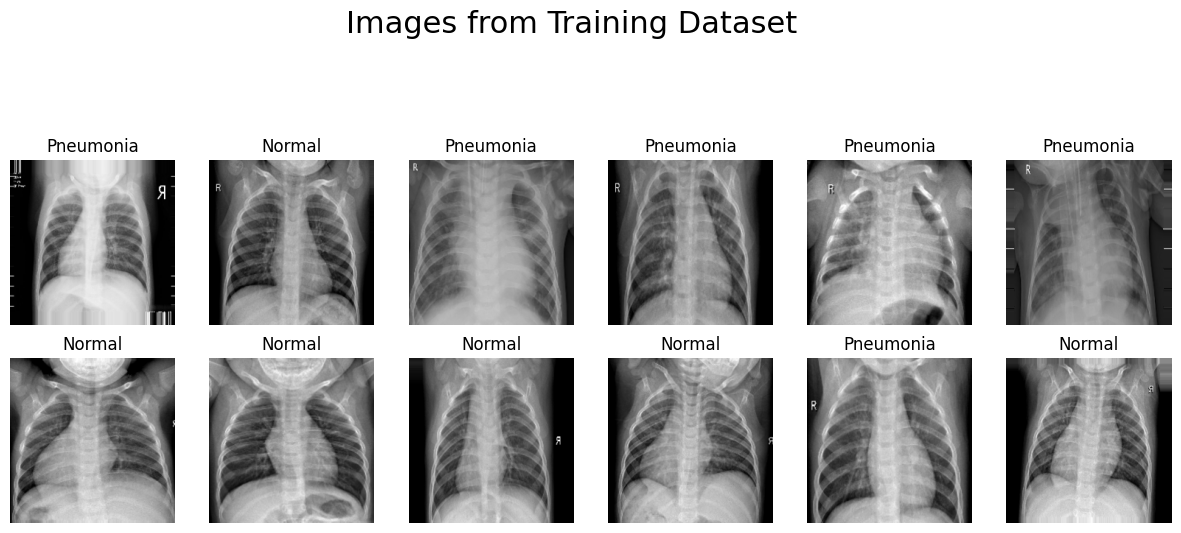

In [54]:
#  visualizing few images from training dataset
plt.figure(figsize=(15,15))
data =next(training_set)
imag = data[0]
label =data[1]

for i in range(12):

    ax=plt.subplot(6,6,i+1)

    plt.imshow(imag[i])
    plt.axis('off')

    if label[i]==0:
        plt.title("Normal")
    else:
        plt.title("Pneumonia")

plt.suptitle('Images from Training Dataset',fontsize=22)
plt.show()

In [75]:

# Get the list of all the images
normal_cases = train_normal.glob('*.jpeg')
pneumonia_cases = train_pneumonia.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,train/PNEUMONIA/person1326_bacteria_3372.jpeg,1
1,train/NORMAL/NORMAL2-IM-1116-0001-0002.jpeg,0
2,train/PNEUMONIA/person1838_bacteria_4703.jpeg,1
3,train/PNEUMONIA/person1230_virus_2081.jpeg,1
4,train/PNEUMONIA/person817_bacteria_2728.jpeg,1


1    3875
0    1341
Name: label, dtype: int64


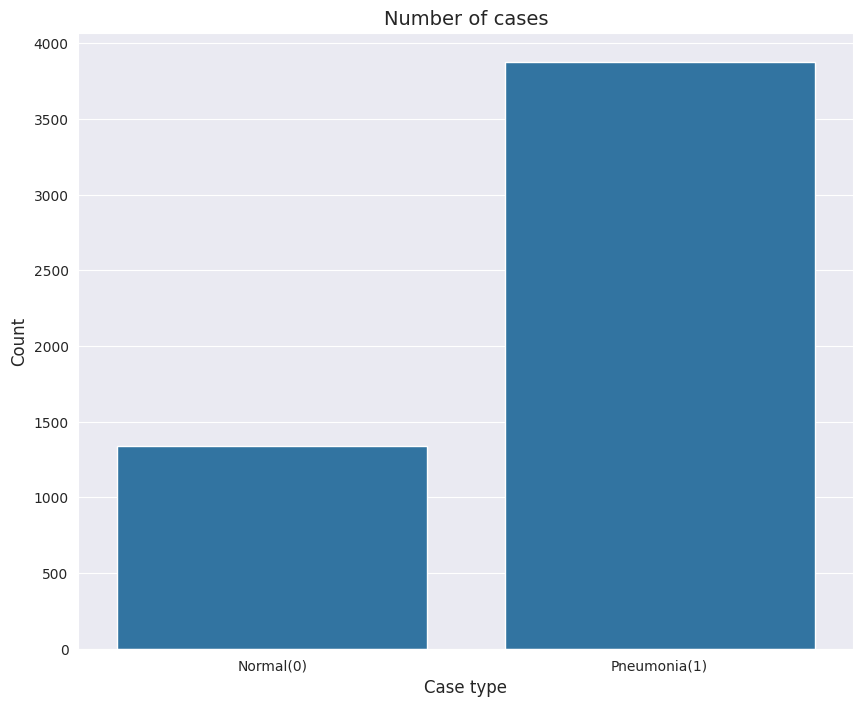

In [76]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

#Build CNN Model

In [57]:
# step based decay learning rate

initial_learning_rate = 0.001
def lr_step_decay(epoch):
    drop_rate = 0.5
    epochs_drop = 3.0
    return initial_learning_rate * math.pow(drop_rate, math.floor((epoch)/epochs_drop))

lrate = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

In [58]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(lr_step_decay(len(self.losses)))

In [59]:
loss_history = LossHistory()
callbacks_list = [loss_history, lrate]

In [60]:
#  initializing convnet layer
model = Sequential()

# 1st convnet layer
model.add(Conv2D(32, 3, activation='relu' , kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())

# 2nd convnet layer
model.add(Conv2D(64, 3, activation='relu' , kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))

# 3rd convnet layer
model.add(Conv2D(128, 3, activation='relu' , kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())

#hidden layer 1
model.add(Dense(128 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# hidden layer 2
model.add(Dense(64 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#hidden layer 3
model.add(Dense(32 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# output layer
model.add(Dense(1 , activation = 'sigmoid'))


METRICS = [
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]



model.compile(optimizer = 'Adam', loss = 'binary_crossentropy' , metrics = METRICS)


#Train the Model

In [65]:
%%time
# training model
history = model.fit(training_set,
                    epochs = 25,
                    validation_data=validation_set,
                    callbacks=callbacks_list)

Epoch 1/25
163/163 [==============================] - 122s 682ms/step - loss: 0.3802 - accuracy: 0.8499 - precision: 0.9410 - recall: 0.8514 - val_loss: 1.4225 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/25
163/163 [==============================] - 108s 662ms/step - loss: 0.2114 - accuracy: 0.9314 - precision: 0.9564 - recall: 0.9510 - val_loss: 2.0523 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/25
163/163 [==============================] - 112s 686ms/step - loss: 0.2042 - accuracy: 0.9252 - precision: 0.9488 - recall: 0.9507 - val_loss: 1.3277 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/25
163/163 [==============================] - 110s 673ms/step - loss: 0.1803 - accuracy: 0.9388 - precision: 0.9604 - recall: 0.9572 - val_loss: 1.2841 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000 - lr: 5.0000e-04
Epoch 5/25
163/163 [============

# Visualizing model performance
Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values for the training.



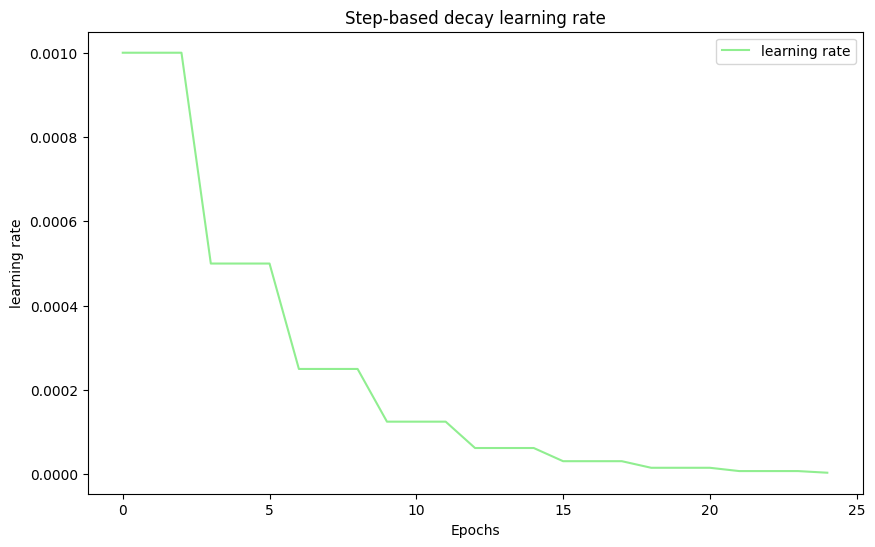

In [66]:
plt.figure(figsize=(10,6))

plt.plot(history.history['lr'],color='lightgreen',label='learning rate')


plt.title('Step-based decay learning rate')
plt.xlabel('Epochs')
plt.ylabel('learning rate')
plt.legend()
plt.show()

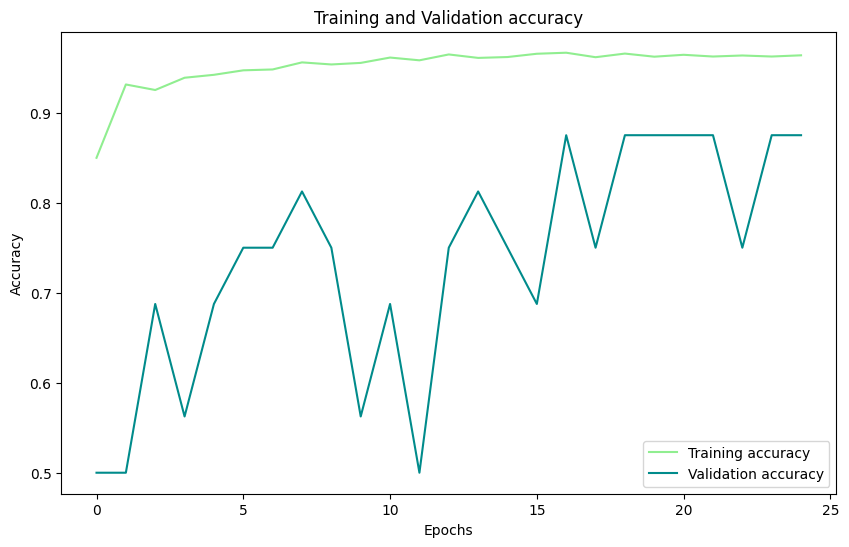

In [67]:
plt.figure(figsize=(10,6))

plt.plot(history.history['accuracy'],color='lightgreen',label='Training accuracy')
plt.plot(history.history['val_accuracy'], color='darkcyan',label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

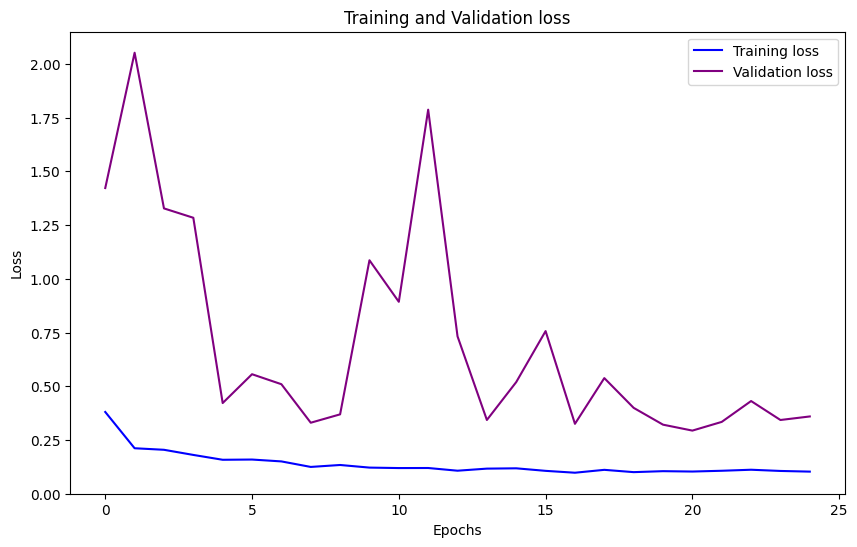

In [68]:
plt.figure(figsize=(10,6))

history_df = pd.DataFrame(history.history)
plt.plot(history_df.loc[:, ['loss']], "blue", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"purple", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

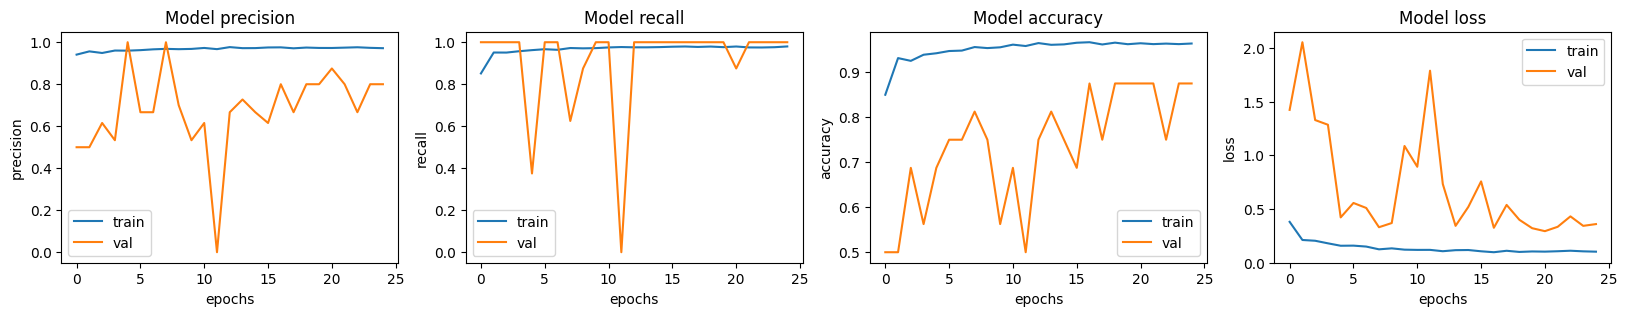

In [69]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#Predict and evaluate results


In [70]:
# model performance for testing data
loss, accuracy, precision, recall = model.evaluate(testing_set)

20/20 [==============================] - 7s 351ms/step - loss: 0.2818 - accuracy: 0.8926 - precision: 0.8782 - recall: 0.9615
